In [1]:
# import libraries (you may add additional imports but you may not have to)
# MAHIM AL MUNTASHIR BILLAH
# Bsc in Computer Science and Technology
# Nantong University, China

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2024-12-31 06:22:24--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M   147MB/s    in 0.2s    

2024-12-31 06:22:24 (147 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [4]:
# add your code here - consider creating a new cell for each section of code
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [5]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [6]:
df = df_ratings.merge(df_books, on='isbn', how='left')

In [7]:
df.head()

,user,isbn,rating,title,author
0,276725,034545104X,0.0,Flesh Tones: A Novel,M. J. Rose
1,276726,0155061224,5.0,Rites of Passage,Judith Rae
2,276727,0446520802,0.0,The Notebook,Nicholas Sparks
3,276729,052165615X,3.0,Help!: Level 1,Philip Prowse
4,276729,0521795028,6.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather


In [8]:
# to ensure statistical significance, remove from the dataset users with
# less than 200 ratings and books with less than 100 ratings.
num_ratings_per_user = df['user'].value_counts()
num_ratings_per_book = df['isbn'].value_counts()
indices_users_at_least_200 = num_ratings_per_user[num_ratings_per_user >= 200].index
indices_books_at_least_100 = num_ratings_per_book[num_ratings_per_book >= 100].index
df = df[(df['user'].isin(indices_users_at_least_200.values)) & (df_ratings['isbn'].isin(indices_books_at_least_100.values))]

In [9]:
df.head()

,user,isbn,rating,title,author
1456,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1469,277427,0060930535,0.0,The Poisonwood Bible: A Novel,Barbara Kingsolver
1471,277427,0060934417,0.0,Bel Canto: A Novel,Ann Patchett
1474,277427,0061009059,9.0,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich
1484,277427,0140067477,0.0,The Tao of Pooh,Benjamin Hoff


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49781 entries, 1456 to 1147441
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    49781 non-null  int32  
 1   isbn    49781 non-null  object 
 2   rating  49781 non-null  float32
 3   title   49517 non-null  object 
 4   author  49517 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 1.9+ MB


In [11]:
df = df.dropna(axis=0)
df = df.drop_duplicates(subset=['title', 'user'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49136 entries, 1456 to 1147441
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    49136 non-null  int32  
 1   isbn    49136 non-null  object 
 2   rating  49136 non-null  float32
 3   title   49136 non-null  object 
 4   author  49136 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 1.9+ MB


In [12]:
df['rating'].describe()

,rating
count,49136.000000
mean,2.014572
std,3.569930
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,10.000000


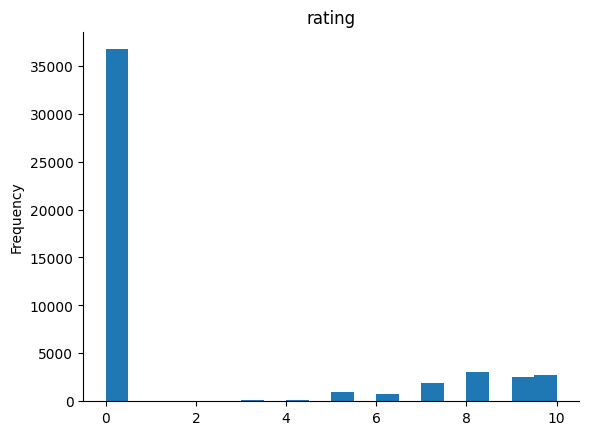

In [13]:
df['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

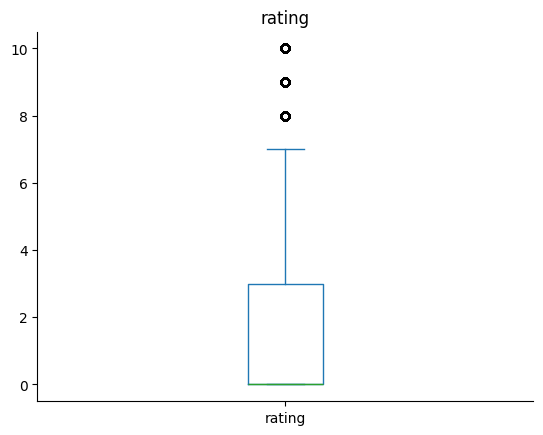

In [14]:
df['rating'].plot(kind='box', title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

In [15]:
pivot_table = df.pivot(index='title', columns='user', values='rating').fillna(0)
pivot_table.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
books_sparse_matrix = csr_matrix(pivot_table.values)

In [17]:
model = NearestNeighbors(metric='cosine')
model.fit(books_sparse_matrix)

NearestNeighbors(metric='cosine')

In [18]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  book_idx = pivot_table.index.get_loc(book)
  distances, indices = model.kneighbors(pivot_table.iloc[book_idx, :].values.reshape(1, -1), n_neighbors=6)

  recommended_books = [book, [
      [pivot_table.index[indices.flatten()[i]], distances.flatten()[i]] for i in range(1, len(distances.flatten()))
  ]]

  recommended_books[1].reverse()

  return recommended_books

In [19]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
